In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas

con = duckdb.connect('../data/db_files/file.db')

# Consulta 1:
Crescimento do PIB per capita e das emissões de GEE's per capita

In [2]:
q = """
    SELECT
        sub.ano,
        sub.media_pib AS mp,
        sub.media_gee AS mg
    FROM (
        SELECT 
            ano,
            AVG(pib_per_capita) AS media_pib,
            AVG(gee_per_capita) AS media_gee
        FROM infos_anuais_paises
        GROUP BY ano
    ) AS sub
    WHERE
        mp IS NOT Null AND
        mg IS NOT Null
"""

resultado = con.execute(q).fetchall()

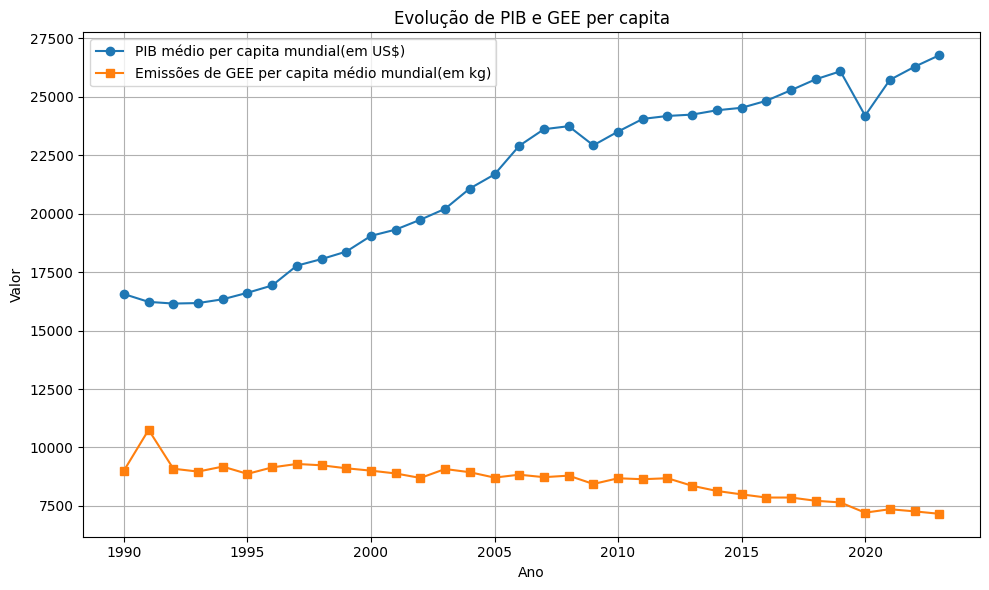

In [3]:

# Separar os dados em três listas
anos = [d[0] for d in resultado]
pib = [d[1] for d in resultado]
gee = [(d[2])*10**3 for d in resultado]

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(anos, pib, label='PIB médio per capita mundial(em US$)', marker='o')
plt.plot(anos, gee, label='Emissões de GEE per capita médio mundial(em kg)', marker='s')

# Personalização
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.title('Evolução de PIB e GEE per capita')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar o gráfico
plt.show()


# Consulta 2:
Top 5 países com maior taxa média de crescimento populacional desde 2000

In [4]:
q="""
WITH crescimento_pop AS (
    SELECT
        ano,
        nome,
        ((populacao - LAG(populacao) OVER (PARTITION BY codigo ORDER BY ano)) 
        / LAG(populacao) OVER (PARTITION BY codigo ORDER BY ano)) * 100 AS crescimento_percentual_medio
    FROM
        infos_anuais_paises
    WHERE
        ano >= 1999
)

SELECT
    nome,
    AVG(crescimento_percentual_medio) as crescimento
FROM 
    crescimento_pop
GROUP BY 
    nome
ORDER BY
    crescimento DESC
LIMIT
    5
"""

resultado=con.execute(q).fetchall()


In [5]:
con.query(q).show()

┌──────────────────────────┬────────────────────┐
│           nome           │    crescimento     │
│         varchar          │       double       │
├──────────────────────────┼────────────────────┤
│ Qatar                    │  6.526641923241606 │
│ United Arab Emirates     │ 5.0194176332105735 │
│ Equatorial Guinea        │  4.342065447546857 │
│ Turks and Caicos Islands │  4.021868879197327 │
│ Bahrain                  │  4.007306536036949 │
└──────────────────────────┴────────────────────┘



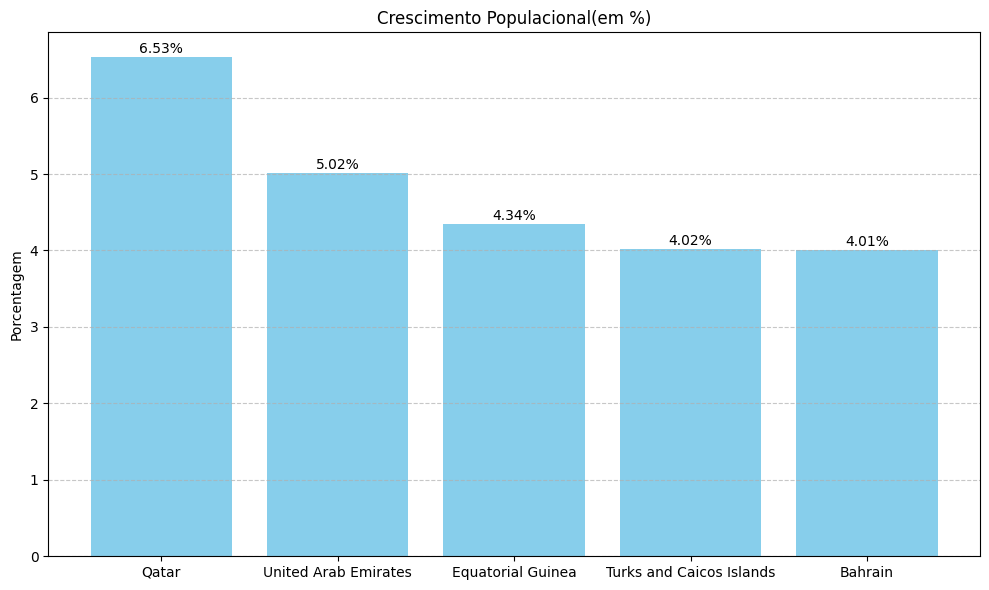

In [6]:
paises = [d[0] for d in resultado]
crescimento = [d[1] for d in resultado]

plt.figure(figsize=(10, 6))
plt.bar(paises, crescimento, color="skyblue")

for i, v in enumerate(crescimento):
    plt.text(paises[i], v + 0.05, f"{v:.2f}%", ha='center')

plt.ylabel('Porcentagem')
plt.title('Crescimento Populacional(em %)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Consulta 3:
Comparação por continente da porcentagem média da participação de fontes renováveis e não renováveis no consumo de cada continente

In [7]:
q="""
SELECT 
    continente,
    ROUND(AVG(fonte_solar + fonte_hidreletrica), 2) AS renovaveis,
    ROUND(AVG(fonte_carvao + fonte_gas + fonte_petroleo + fonte_nuclar), 2) AS nao_renovaveis,
    ROUND(AVG(pib_per_capita), 2) as "pib_percapita(US$)"
FROM infos_anuais_paises
GROUP BY continente
ORDER BY renovaveis DESC;
"""

r=con.execute(q).fetchdf()


In [8]:
con.sql(q).show()

┌───────────────┬────────────┬────────────────┬────────────────────┐
│  continente   │ renovaveis │ nao_renovaveis │ pib_percapita(US$) │
│    varchar    │   double   │     double     │       double       │
├───────────────┼────────────┼────────────────┼────────────────────┤
│ South America │      22.01 │           77.0 │           15558.79 │
│ Oceania       │      21.96 │          78.21 │           11650.04 │
│ Europe        │       9.72 │          88.69 │            37239.8 │
│ North America │       9.68 │          87.28 │            26721.9 │
│ Asia          │       4.95 │          94.39 │            25232.5 │
│ Africa        │       2.51 │           96.0 │            5783.35 │
└───────────────┴────────────┴────────────────┴────────────────────┘



# Consulta 4:
Países detentores das maiores anomalias de temperatura de cada ano

In [9]:
q="""
SELECT 
    ano, 
    nome, 
    anomalia_temperatura
FROM (
    SELECT 
        ano,
        nome,
        anomalia_temperatura,
        RANK() OVER (PARTITION BY ano ORDER BY anomalia_temperatura DESC) AS rank_anomalia
    FROM infos_anuais_paises
    WHERE anomalia_temperatura IS NOT NULL
    QUALIFY rank_anomalia = 1
)
ORDER BY ano
"""

r=con.execute(q).fetchall()

In [10]:
con.sql(q).show()

┌───────┬──────────────────────────┬──────────────────────┐
│  ano  │           nome           │ anomalia_temperatura │
│ int32 │         varchar          │        double        │
├───────┼──────────────────────────┼──────────────────────┤
│  1960 │ Lebanon                  │           0.37372816 │
│  1961 │ Paraguay                 │           0.44635916 │
│  1962 │ Bahrain                  │            0.5276861 │
│  1963 │ Paraguay                 │           0.30049977 │
│  1964 │ Central African Republic │            0.5567338 │
│  1965 │ Central African Republic │           0.12888718 │
│  1966 │ Georgia                  │            1.3220006 │
│  1967 │ Uruguay                  │        -0.0037249725 │
│  1968 │ Argentina                │        -0.0066517196 │
│  1969 │ Cabo Verde               │           0.36923647 │
│    ·  │     ·                    │                 ·    │
│    ·  │     ·                    │                 ·    │
│    ·  │     ·                    │    

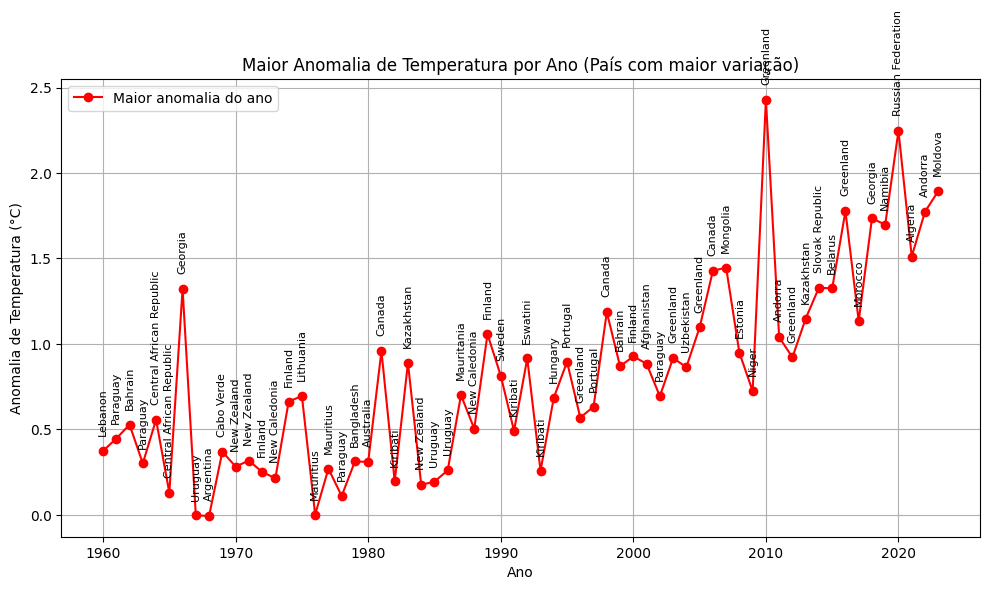

In [11]:
df = con.execute(q).fetchdf()

# Separar os dados
anos = df["ano"]
anomalias = df["anomalia_temperatura"]
paises = df["nome"]

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(anos, anomalias, marker='o', linestyle='-', color='red', label='Maior anomalia do ano')

# Adiciona o nome do país em cada ponto (opcional)
for i in range(len(anos)):
    plt.text(anos[i], anomalias[i] + 0.1, paises[i], ha='center', fontsize=8, rotation=90)

# Estilização
plt.title('Maior Anomalia de Temperatura por Ano (País com maior variação)')
plt.xlabel('Ano')
plt.ylabel('Anomalia de Temperatura (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Consulta 5:
Relação entre o crescimento da economia de cada pais

In [12]:
q="""
WITH crescimento_eco_anual AS (
    SELECT
        nome,
        ano,
        continente,
        pib_per_capita,
        populacao,
        LAG(pib_per_capita) OVER (PARTITION BY codigo ORDER BY ano) AS pib_ant,
        LAG(populacao) OVER (PARTITION BY codigo ORDER BY ano) AS pop_ant
    FROM 
        infos_anuais_paises
    WHERE 
        ano >= 2015
)

SELECT
    continente, 
    ROUND(AVG(
        ((pib_per_capita * populacao - pib_ant * pop_ant) / (pib_ant * pop_ant)) * 100), 2
    ) AS crescimento_economico_porcentagem,
    ROUND(AVG(
        ((populacao - pop_ant) / (pop_ant)) * 100), 2
    ) AS crescimento_pop_porcentagem,
    ROUND(crescimento_economico_porcentagem/crescimento_pop_porcentagem, 2) AS razao
FROM 
    crescimento_eco_anual
WHERE 
    pib_ant IS NOT NULL AND 
    pop_ant IS NOT NULL
GROUP BY
    continente
ORDER BY
    razao DESC
"""
resultado = con.execute(q).fetchall()
con.sql(q).show()

┌───────────────┬───────────────────────────────────┬─────────────────────────────┬────────┐
│  continente   │ crescimento_economico_porcentagem │ crescimento_pop_porcentagem │ razao  │
│    varchar    │              double               │           double            │ double │
├───────────────┼───────────────────────────────────┼─────────────────────────────┼────────┤
│ Europe        │                               2.6 │                        0.21 │  12.38 │
│ South America │                              3.31 │                         1.0 │   3.31 │
│ Oceania       │                              1.81 │                        0.71 │   2.55 │
│ North America │                              1.62 │                        0.64 │   2.53 │
│ Asia          │                              2.93 │                        1.39 │   2.11 │
│ Africa        │                              3.01 │                        2.31 │    1.3 │
└───────────────┴───────────────────────────────────┴─────────────────

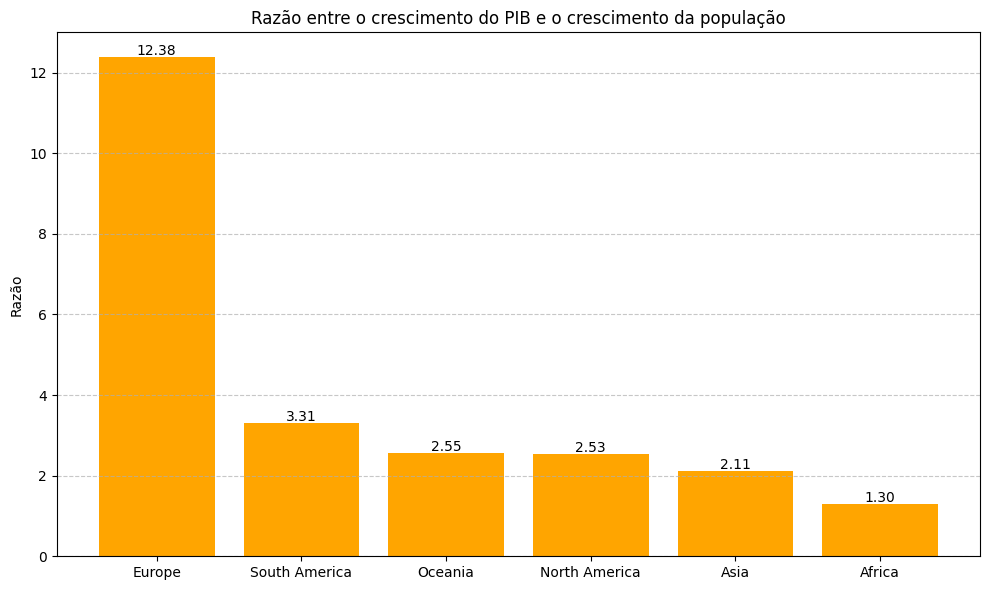

In [13]:
paises = [d[0] for d in resultado]
razao = [d[3] for d in resultado]

plt.figure(figsize=(10, 6))
plt.bar(paises, razao, color="orange")

for i, v in enumerate(razao):
    plt.text(paises[i], v + 0.05, f"{v:.2f}", ha='center')

plt.ylabel('Razão')
plt.title('Razão entre o crescimento do PIB e o crescimento da população')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()